### Sparse Representation

O objetivo destes exemplos é fazer um processo similar ao da aula anterior,
onde obtivemos um vetor esparso $s$ a partir de uma otimização $\ell_1$ em $y = \Theta s$.

Porém agora, ao invés de um sinal, estaremos trabalhando com o conjunto de imagens das eigenfaces.

A abordagem geral também muda um pouco: dividimos o dataset entre treino e teste.
As imagens de treino entram em $\Theta$ e as de teste são os $y$ para quais os $s$ serão ajustados.

Esse experimento também traz um aspecto de dimensionaldiade reduzida: as imagens não são adicionadas aos conjuntos
em sua resolução original, e sim em uma resolução reduzida.

A ideia é que, como temos varias imagens para um mesmo rosto, as imagens de um rosto $k$ presentes em $\Theta$
nos ajudem a reconstruí-lo em alta dimensionalidade a partir de um $s_k$ ajustado a um $y_k$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse import csr_matrix
import os
import scipy.io
#from sklearn import linear_model
#from sklearn import model_selection
from scipy.optimize import minimize
from skimage.transform import resize
from matplotlib.image import imread

In [31]:
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams.update({'font.size': 18, 'mathtext.default': 'regular'})

mustache = imread(os.path.join('..','data','mustache.jpg'))
mustache = np.mean(mustache, -1); # Convert RGB to grayscale
mustache = (mustache/255).astype(int)
mustache = mustache.T

mat = scipy.io.loadmat(os.path.join('..','data','allFaces.mat'))
X = mat['faces']
nfaces = mat['nfaces'].reshape(-1)
n = mat['n']
n = int(n)
m = mat['m']
m = int(m)

C:\Users\Daniel Serezane\AppData\Local\Temp\ipykernel_10212\3464794320.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(n)
C:\Users\Daniel Serezane\AppData\Local\Temp\ipykernel_10212\3464794320.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(m)


In [5]:
print(n, m)

192 168


Separamos o conjunto entre treino e teste.

In [6]:
## Build Training and Test sets
nTrain = 30
nTest = 20
nPeople = 20
Train = np.zeros((X.shape[0],nTrain*nPeople))
Test = np.zeros((X.shape[0],nTest*nPeople))

for k in range(nPeople):
    baseind = 0
    if k > 0:
        baseind = np.sum(nfaces[:k])
    inds = range(baseind,baseind+nfaces[k])
    Train[:,k*nTrain:(k+1)*nTrain] = X[:,inds[:nTrain]]
    Test[:,k*nTest:(k+1)*nTest] = X[:,inds[nTrain:(nTrain+nTest)]]

Fazemos o downsample das imagens de treino e adicionamos na matriz $\Theta$ como colunas. As imagens são reduzidas de $168 \times 192$ para $10 \times 12$.

In [8]:
## Downsample Training Images (Build Theta)
M = Train.shape[1]

Theta = np.zeros((120,M))
for k in range(M):
    temp = np.reshape(np.copy(Train[:,k]),(m,n))
    tempSmall = resize(temp, (10, 12), anti_aliasing=True)
    Theta[:,k] = np.reshape(tempSmall, 120)

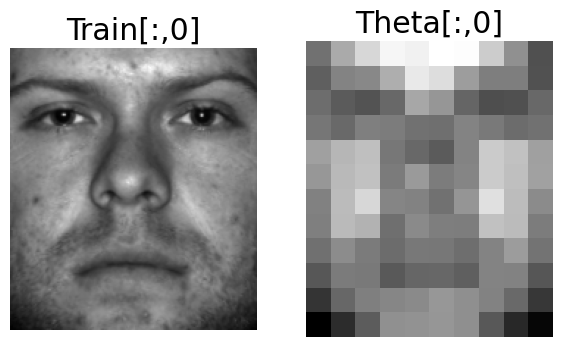

In [11]:
# plot Train[:,0] and Theta[:,0] side by side
plt.subplot(1,2,1)
plt.imshow(np.reshape(Train[:,0],(m,n)).T, cmap='gray')
plt.axis('off')
plt.title('Train[:,0]')
plt.subplot(1,2,2)
plt.imshow(np.reshape(Theta[:,0],(10,12)).T, cmap='gray')
plt.axis('off')
plt.title('Theta[:,0]')
plt.show()

Normalizando os valores.

In [12]:
## Renormalize Columns of Theta
normTheta = np.zeros(M)
for k in range(M):
    normTheta[k] = np.linalg.norm(Theta[:,k])
    Theta[:,k] = Theta[:,k]/normTheta[k]

Adicionando o "bigode" em uma imagem de teste.
A ideia é ver se o modelo é capaz de reconstruir o rosto mesmo com essa oclusão.

In [15]:
## Occlude Test Image (Test[:,125] = test image 6, person 7)
x1 = np.copy(Test[:,125]) # Clean image
x2 = np.copy(Test[:,125]) * mustache.reshape(n*m)
randvec = np.random.permutation(n*m)
first30 = randvec[:int(np.floor(0.3*len(randvec)))]
vals30 = (255*np.random.rand(*first30.shape)).astype(int)
x3 = np.copy(x1)
x3[first30] = vals30 # 30% occluded
x4 = np.copy(x1) + 50*np.random.randn(*x1.shape) # Random noise

Agora fazemos no conjunto de teste o mesmo que fizemos no treino: downsample, flatten, e inserção dos resultados nas colunas de uma matriz $Y$.

Temos apenas 4 exemplos de teste.

In [16]:
## Downsample Test Images
X = np.zeros((x1.shape[0],4))
X[:,0] = x1
X[:,1] = x2
X[:,2] = x3
X[:,3] = x4

Y = np.zeros((120,4))
for k in range(4):
    temp = np.reshape(np.copy(X[:,k]),(m,n))
    tempSmall = resize(temp, (10, 12), anti_aliasing=True)
    Y[:,k] = np.reshape(tempSmall,120)

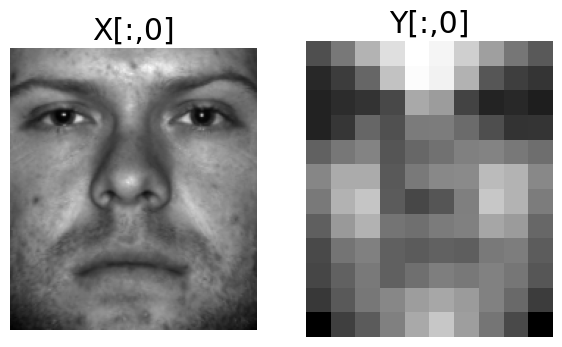

In [40]:
# plot X[:,0] and Y[:,0] side by side
plt.subplot(1,2,1)
plt.imshow(np.reshape(X[:,0],(m,n)).T, cmap='gray')
plt.axis('off')
plt.title('X[:,0]')
plt.subplot(1,2,2)
plt.imshow(np.reshape(Y[:,0],(10,12)).T, cmap='gray')
plt.axis('off')
plt.title('Y[:,0]')
plt.show()

Vamos ao primeiro exemplo.

Calculamos $s_1$, $y_1 = \Theta s_1$ usando a otimização $\ell_1$.

Ou seja, queremos obter $\s_1$ esparso de forma que 

In [17]:
## L1 Search, Testclean
y1 = np.copy(Y[:,0])
eps = 0.01

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y1,2)})
x0 = np.linalg.pinv(Theta) @ y1 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s1 = res.x

In [18]:
x0.shape, Theta.shape, y1.shape

((600,), (120, 600), (120,))

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Daniel Serezane\AppData\Local\Temp\ipykernel_10212\2181676245.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mathregular{s_j}$')


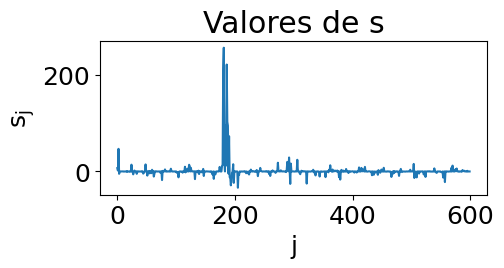

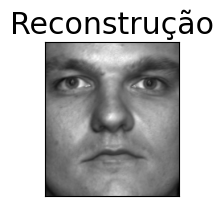

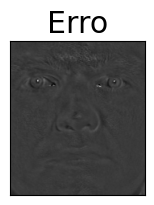

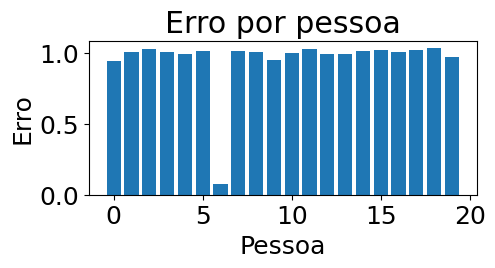

In [34]:
plt.figure(figsize=(5,2))
plt.plot(s1)
plt.title('Valores de s')
plt.ylabel('$\mathregular{s_j}$')
plt.xlabel('j')
plt.figure(figsize=(2,2))
plt.xticks([])
plt.yticks([])
plt.title('Reconstrução')
plt.imshow(np.reshape(Train @ (s1/normTheta),(m,n)).T,cmap='gray')
plt.figure(figsize=(2,2))
plt.xticks([])
plt.yticks([])
plt.title('Erro')
plt.imshow(np.reshape(x1 - Train @ (s1/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x1-Train[:,L] @ (s1[L]/normTheta[L]))/np.linalg.norm(x1)
    
plt.figure(figsize=(5,2))
plt.title('Erro por pessoa')
plt.ylabel('Erro')
plt.xlabel('Pessoa')
plt.bar(range(nPeople),binErr)
plt.show()

In [35]:
## L1 Search, Mustache
y2 = np.copy(Y[:,1])
eps = 500

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y2,2)})
x0 = np.linalg.pinv(Theta) @ y2 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s2 = res.x

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Daniel Serezane\AppData\Local\Temp\ipykernel_10212\3762658907.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mathregular{s_j}$')


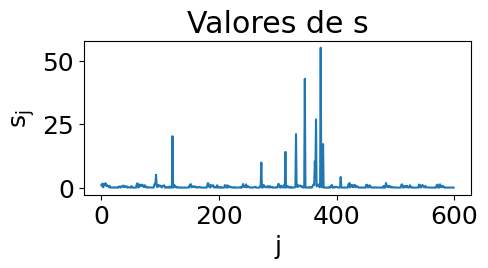

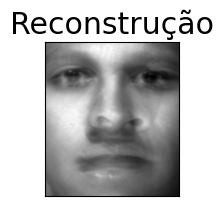

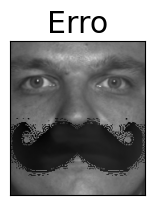

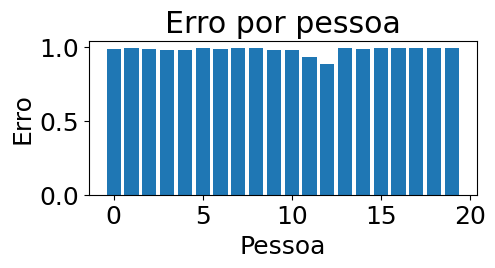

In [39]:
plt.figure(figsize=(5,2))
plt.title('Valores de s')
plt.ylabel('$\mathregular{s_j}$')
plt.xlabel('j')
plt.plot(s2)
plt.figure(figsize=(2,2))
plt.xticks([])
plt.yticks([])
plt.title('Reconstrução')
plt.imshow(np.reshape(Train @ (s2/normTheta),(m,n)).T,cmap='gray')
plt.figure(figsize=(2,2))
plt.xticks([])
plt.yticks([])
plt.title('Erro')
plt.imshow(np.reshape(x2 - Train @ (s2/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x2-Train[:,L] @ (s2[L]/normTheta[L]))/np.linalg.norm(x2)
    
plt.figure(figsize=(5,2))
plt.title('Erro por pessoa')
plt.ylabel('Erro')
plt.xlabel('Pessoa')
plt.bar(range(nPeople),binErr)
plt.show()

In [12]:
## L1 Search, Occlusion
y3 = np.copy(Y[:,2])
eps = 1000

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y3,2)})
x0 = np.linalg.pinv(Theta) @ y3 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s3 = res.x

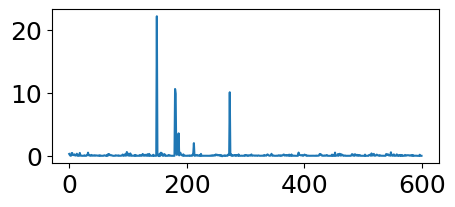

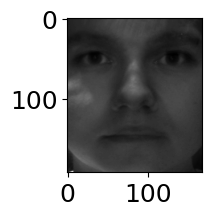

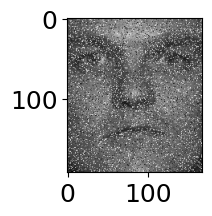

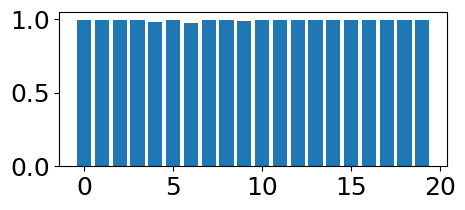

In [13]:
plt.figure(figsize=(5,2))
plt.plot(s3)
plt.figure(figsize=(2,2))
plt.imshow(np.reshape(Train @ (s3/normTheta),(m,n)).T,cmap='gray')
plt.figure(figsize=(2,2))
plt.imshow(np.reshape(x3 - Train @ (s3/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x3-Train[:,L] @ (s3[L]/normTheta[L]))/np.linalg.norm(x3)
    
plt.figure(figsize=(5,2))
plt.bar(range(nPeople),binErr)
plt.show()

In [14]:
## L1 Search, Noise
y4 = np.copy(Y[:,3])
eps = 10

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y4,2)})
x0 = np.linalg.pinv(Theta) @ y4 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s4 = res.x

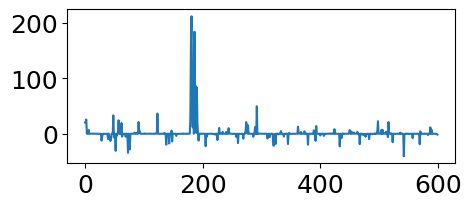

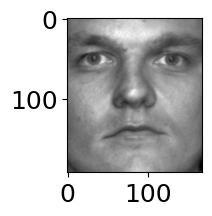

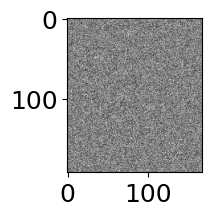

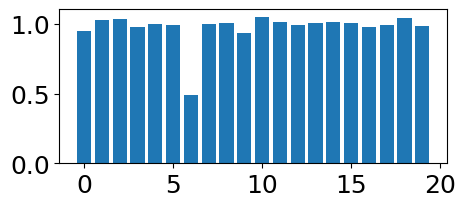

In [15]:
plt.figure(figsize=(5,2))
plt.plot(s4)
plt.figure(figsize=(2,2))
plt.imshow(np.reshape(Train @ (s4/normTheta),(m,n)).T,cmap='gray')
plt.figure(figsize=(2,2))
plt.imshow(np.reshape(x4 - Train @ (s4/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x4-Train[:,L] @ (s4[L]/normTheta[L]))/np.linalg.norm(x4)
    
plt.figure(figsize=(5,2))
plt.bar(range(nPeople),binErr)
plt.show()

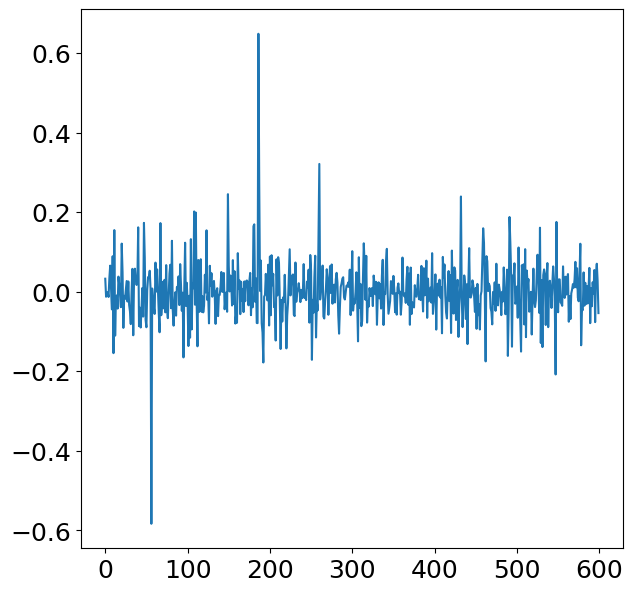

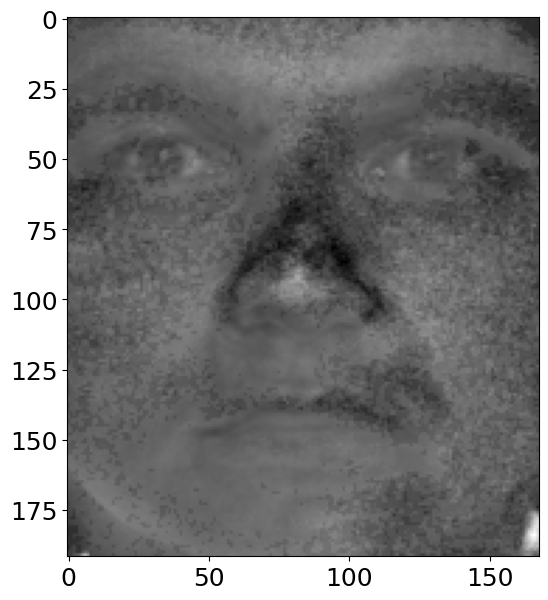

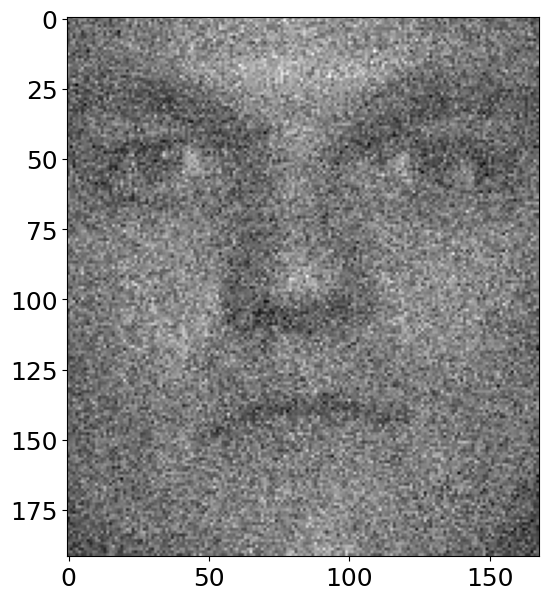

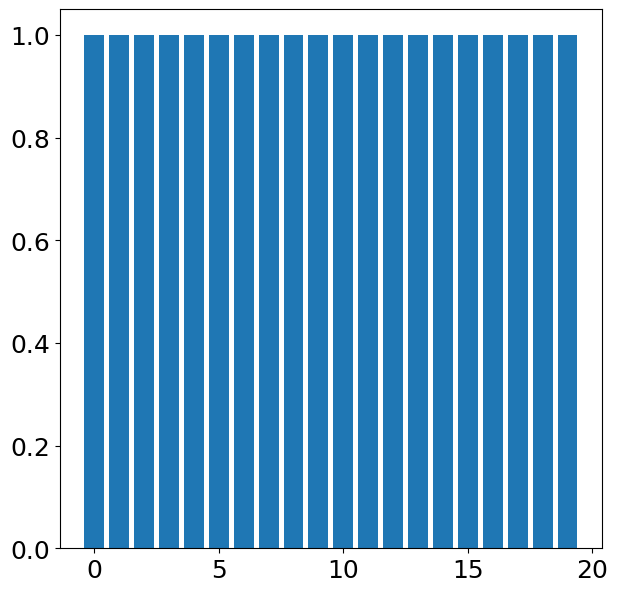

In [16]:
## Least Squares Is No Good
s4L2 = np.linalg.pinv(Train) @ x4
plt.figure()
plt.plot(s4L2)
plt.figure()
plt.imshow(np.reshape(Train @ (s4L2/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x4 - Train @ (s4L2/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x4-Train[:,L] @ (s4L2[L]/normTheta[L]))/np.linalg.norm(x4)
    
plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

### Sparse Sensor Placement

In [4]:
faces = mat['faces']

In [5]:
faces.shape

(32256, 2410)

In [6]:
U_tilde,s_tilde,V_tilde = linalg.svd(faces,full_matrices=False)

In [79]:
r = 100

Psi_r = U_tilde[:,:r]

In [80]:
Q,R,pivot = linalg.qr(Psi_r.T,pivoting=True)
C = np.zeros_like(Psi_r.T)
C[:, pivot[:r]] = 1
for k in range(r):
    C[k,pivot[k]] = 1

Verificando $\Psi_r^T C^T = QR$

In [90]:
(Psi_r.T @ C.T).shape

(100, 100)

In [100]:
(Q @ R).shape

(100, 32256)

In [105]:
Theta = np.dot(C, Psi_r)
y = faces[pivot[:r]]
a = np.dot(np.linalg.pinv(Theta),y)
faceRecon = np.dot(Psi_r , a) 

In [124]:
# marcando os sensores
sensors = np.zeros_like(faces[:, 0])
sensors[pivot[:r]] = 1
sensors = np.reshape(sensors, (m, n))
sensors.shape

(168, 192)

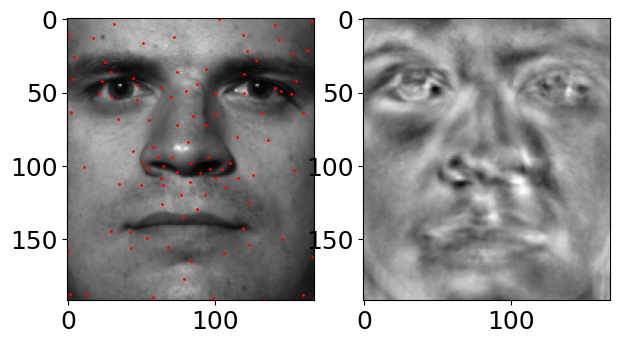

In [127]:
# plot first face
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(faces[:,200],(m,n)).T,cmap='gray')
ax[1].imshow(np.reshape(faceRecon[:,200],(m,n)).T,cmap='gray')
# plot sensors on first face
ax[0].scatter(np.where(sensors == 1)[0], np.where(sensors == 1)[1], c='r', s=1)
plt.show()